In [2]:
from sklearn import preprocessing
import os
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/home/eferos93/github/statistical-machine-learning/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
covid19 = pd.read_csv("COVID_national_20200421.csv")
covid19_cleaned = covid19.drop(
    ["ICU", "Unnamed: 0", "new_infections", "hospitalized", "cumulative_infections", "recovered", "quarantined"],
    axis='columns')
covid19_cleaned['date'] = pd.to_datetime(covid19_cleaned['date'])
covid19_cleaned.info()
covid19_cleaned.set_index('date', inplace=True)
covid19_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    58 non-null     datetime64[ns]
 1   deaths  58 non-null     int64         
 2   swabs   58 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.5 KB


,deaths,swabs
date,,
2020-02-24,7,4324
2020-02-25,10,8623
2020-02-26,12,9587
2020-02-27,17,12014
2020-02-28,21,15695


In [4]:
def normalise_column(col):
    """
    Normalisation of the given vector
    @param col Columns to be normalised
    @return Normalised column
    """
    return (col - col[0]) / np.std(col)


covid19_normalised = covid19_cleaned

covid19_normalised = covid19_normalised.apply(normalise_column)
covid19_normalised.tail()

,deaths,swabs
date,,
2020-04-17,2.652017,2.815004
2020-04-18,2.708234,2.955155
2020-04-19,2.758737,3.070290
2020-04-20,2.811689,3.164480
2020-04-21,2.873971,3.282835


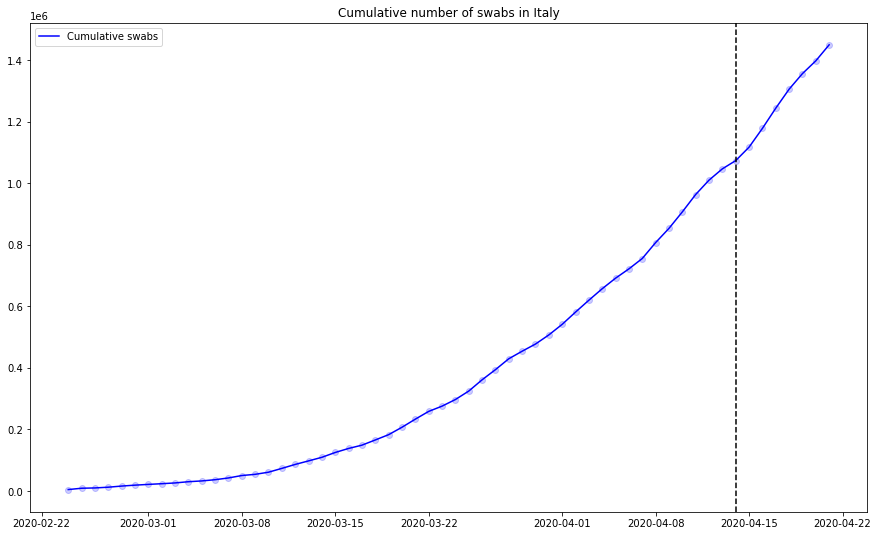

In [5]:
def plot_data(x_data, y_data, label_function: str, title: str):
    fig, ax = plt.subplots(1, 1, figsize=(15, 9))
    ax.plot(x_data, y_data,
            color='b', label=label_function)
    ax.plot(x_data, y_data,
            color='b', marker='o', linestyle='', alpha=0.2)
    ax.axvline(pd.to_datetime("2020-04-14"), linestyle='--', color='k')
    ax.legend()
    ax.set_title(title)


def plot_predictions(gauss_process_regressor, label: str,
                     obs_output, obs_input, x_label=covid19_normalised.index.values,
                     include_observed=True):
    pred_y, pred_std = gauss_process_regressor.predict(obs_input, return_std=True)
    plt.figure(figsize=(15, 9))
    if include_observed:
        plt.plot(x_label, obs_output, 'ok', alpha=0.1, label=label+" observed", color='r')
    l, = plt.plot(x_label, pred_y, label=label+" prediction")
    plt.fill_between(x_label,
                     pred_y + pred_std,
                     pred_y - pred_std,
                     color=l.get_color(), alpha=0.3)
    plt.axvline(pd.to_datetime("2020-04-14"), linestyle='--', color='k')
    plt.legend()


plot_data(covid19_cleaned.index.values, covid19_cleaned.swabs.values,
          'Cumulative swabs',
          'Cumulative number of swabs in Italy')

In [6]:
def split_data_set(data_set, output_label: str, index=pd.to_datetime("2020-04-14")):
    """
    Separate the data set fir in train and test set
    """
    sep_idx = data_set.index.searchsorted(index)
    data_early = data_set.iloc[:sep_idx+1, :]
    # data_later = data_set.iloc[sep_idx:, :]
    X = data_set.drop(output_label, axis=1).to_numpy()
    y = data_set[output_label].values
    X_train = X[:len(data_early), :]
    y_train = y[:len(data_early)]
    X_test = X[len(data_early):, :]
    y_test = y[len(data_early):]
    # return {'train_set': (X_train, y_train), 'test_set': (X_test, y_test), 'full_set': (X, y)}
    return X_train, y_train, X_test, y_test, X, y

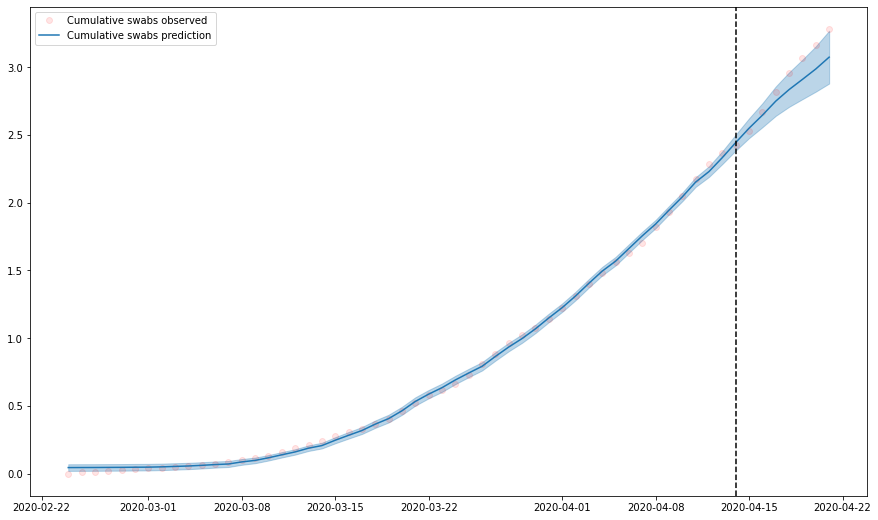

In [6]:
X_train, y_train, X_test, y_test, X, y = split_data_set(covid19_normalised, 'swabs')

k1 = 50**2*RBF(length_scale=50.0)  # Long term trend

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=k1, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp0.fit(X_train, y_train)

plot_predictions(gp0, "Cumulative swabs", y, X,)

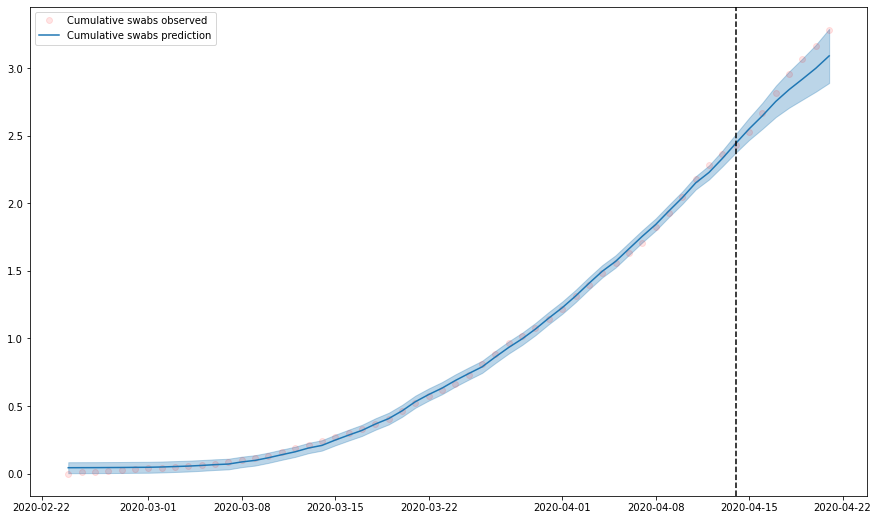

In [7]:
k1 = 50**2 * RBF(length_scale=50.0)
k4 = 1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.5**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k4
gp1 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=False,
                               n_restarts_optimizer=3)
gp1.fit(X_train, y_train)
plot_predictions(gp1, 'Cumulative swabs', y, X)

This might be the best solution.

# Daily number of swabs

In [8]:
covid19_daily_swabs = covid19_cleaned
# del covid19_daily_swabs
# covid19_daily_swabs = covid19_cleaned
# first element after diff() will be NaN, 
# thus I substitute it with the actual value
covid19_daily_swabs['swabs'] = covid19_daily_swabs['swabs'].diff().fillna(4324)

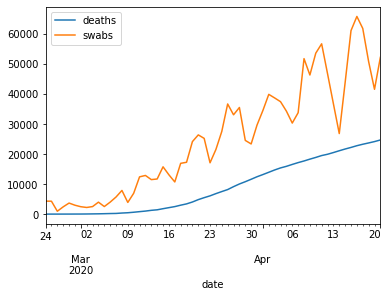

In [9]:
_ = covid19_daily_swabs.plot()

In [10]:
covid19_daily_swabs = covid19_daily_swabs.apply(normalise_column)
X_train, y_train, X_test, y_test, X, y = split_data_set(covid19_daily_swabs, 'swabs')

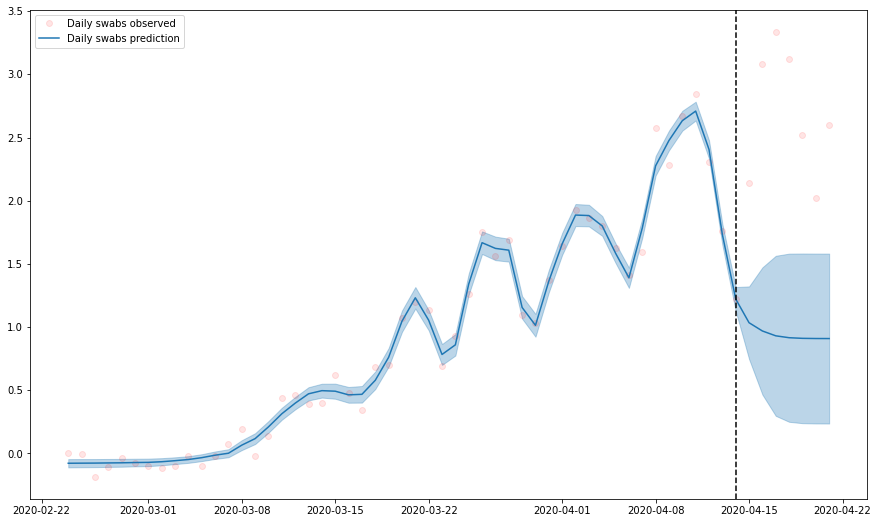

In [16]:
k1 = 50**2*RBF(length_scale=50.0)  # Long term trend

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=k1, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp0.fit(X_train, y_train)

plot_predictions(gp0, "Daily swabs", y, X)

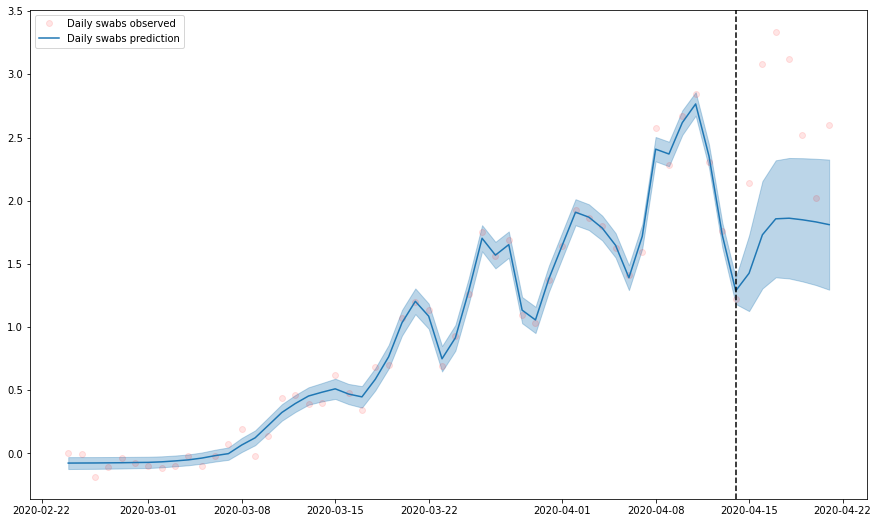

In [29]:
k1 = 50**2 * RBF(length_scale=50.0)
k4 = 1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.5**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k4
gp1 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=False,
                               n_restarts_optimizer=3)
gp1.fit(X_train, y_train)
plot_predictions(gp1, 'Daily swabs', y, X)
plt.savefig('daily_swabs.png')

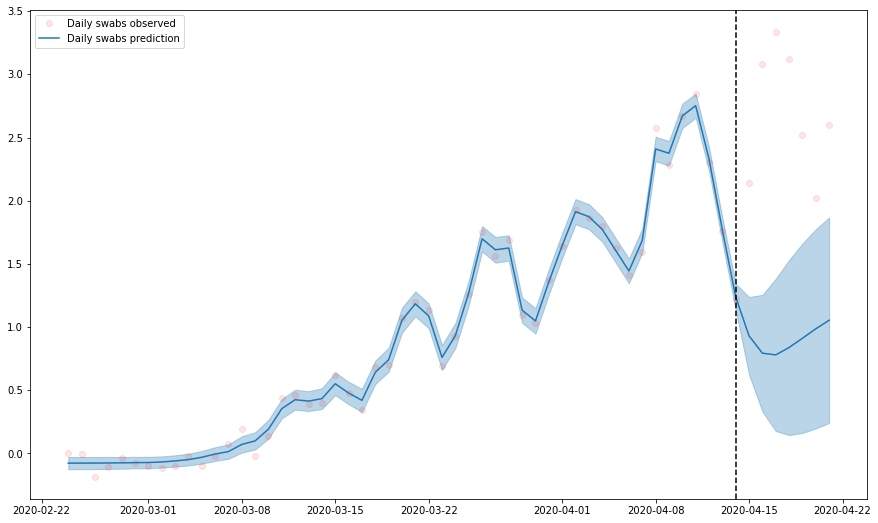

In [19]:
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
# medium term irregularities
k3 = 50**2 * RationalQuadratic(length_scale=10.0, alpha=10.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k3 + k4

gp_full = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                                   normalize_y=False,
                                   n_restarts_optimizer=3)

gp_full.fit(X_train, y_train)
plot_predictions(gp_full, 'Daily swabs', y, X)

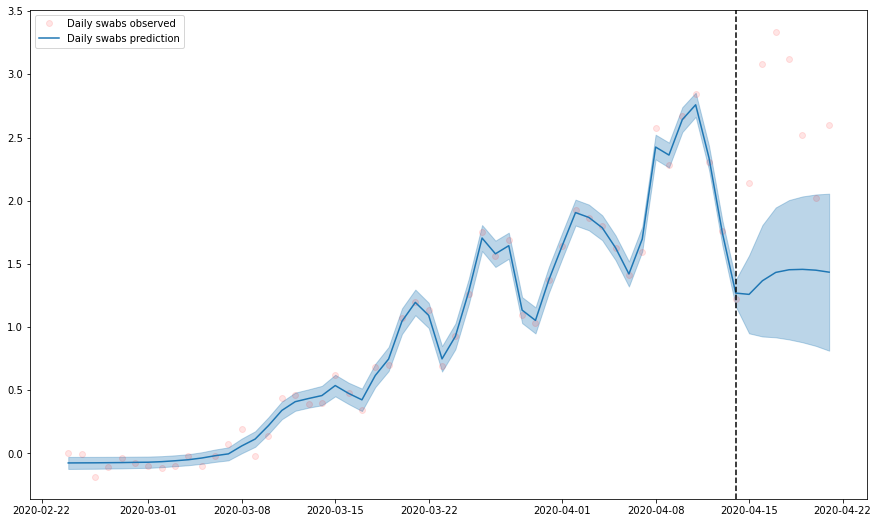

In [27]:
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k2 + k3 + k4

gp_full = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                                   normalize_y=True,
                                   n_restarts_optimizer=3)

gp_full.fit(X_train, y_train)
plot_predictions(gp_full, 'Daily swabs', y, X)
plt.savefig('daily_swabs.png')

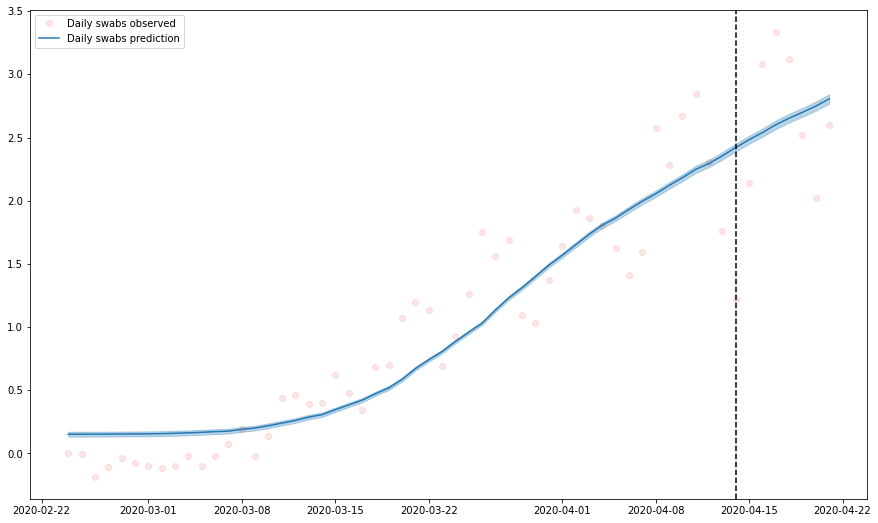

In [21]:
from sklearn.gaussian_process.kernels import DotProduct
import sklearn.gaussian_process.kernels as kernels
k_dot = DotProduct()

gp = GaussianProcessRegressor(kernel=k_dot, alpha=0.01,
                              normalize_y=True,
                              n_restarts_optimizer=3)

gp.fit(X_train, y_train)
plot_predictions(gp, 'Daily swabs', y, X)
plt.savefig('plt_daily swabs.png')

Finally we can see that the dot product is able to capture better the long term pattern for the daily swabs. Now I will try to optimise it.

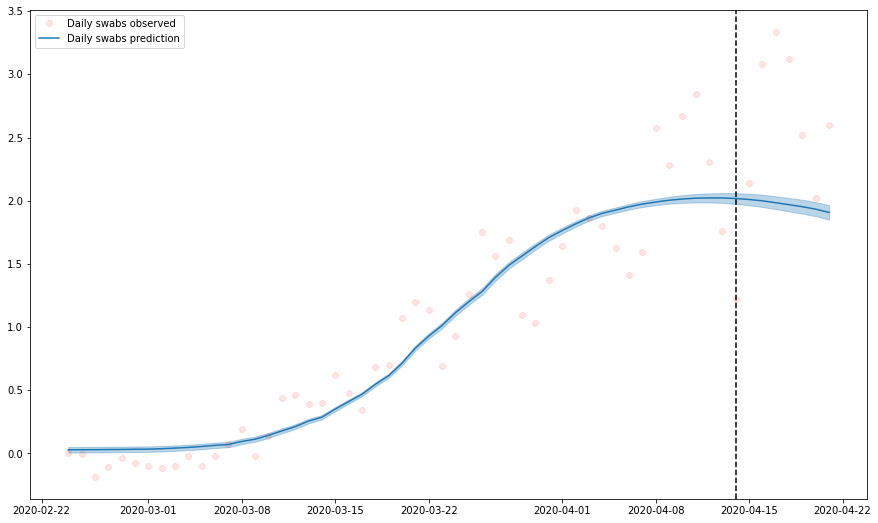

In [18]:
k_dot_v2 = kernels.Exponentiation(k_dot, 1.5)

gp = GaussianProcessRegressor(kernel=k_dot_v2, alpha=0.01,
                              normalize_y=True,
                              n_restarts_optimizer=3)

gp.fit(X_train, y_train)
plot_predictions(gp, 'Daily swabs', y, X)

Exponentiation doesn't work. I used it because in the documentaion of the DotProduct kernel says they are frequently used together.

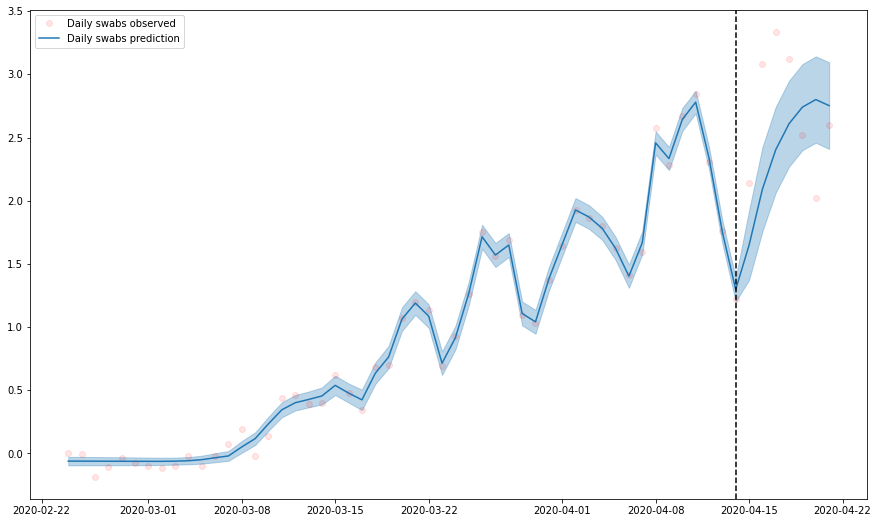

In [91]:
k1 = 1000**2 * RBF(length_scale=1.0)
k2 = 1**(1/2)*kernels.ExpSineSquared(periodicity=1.5, length_scale=10)
k_dot = DotProduct(sigma_0=1)
kernel = k1 + 50**10*k_dot + k2

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                              normalize_y=True,
                              n_restarts_optimizer=3)
gp.fit(X_train, y_train)
plot_predictions(gp, 'Daily swabs', y, X)
plt.savefig('plt_daily_swabs.png')

This looks to be the best as it captures the increasing sinusoidal pattern. However the real curve in the last week in more "narrow" and I think this cannot be predicted exactly